In [51]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from pymongo import MongoClient
from nltk.corpus import stopwords
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import bson
import seaborn as sns

In [3]:
with open('/home/sabinogs/projetos/tcc/dump/test/reviews.bson', 'rb') as b:
    df = pd.DataFrame(bson.decode_all(b.read()))

In [4]:
comentarios = df[df['requirement_type'].isin(['non-functional requirement', 'other', 'functional requirement'])]
df = df[['reviewText','summary','requirement_type']]
df['pre'] = pd.Series()
comentarios = comentarios[['reviewText','summary','requirement_type']]

In [5]:
comentarios.shape

(4784, 3)

In [6]:
def remove_stopwords_sentences(sentences):
    word_without_stop = list()
    for sent in sentences:
        aux = list()
        for word in sent:
            if word not in stopwords.words('english'):
                aux.append(word)
        word_without_stop.append(aux)
    
    return word_without_stop


def remove_stopwords(words):
    return [word for word in words if word not in stopwords.words('english')]

def lemmatize_sentences(sentences):
    lemma = nltk.WordNetLemmatizer()
    lw = list()
    for sent in sentences:
        aux = list()
        for word in sent:
            aux.append(lemma.lemmatize(word))
        lw.append(aux)
    
    return lw

def lemmatize_it(words):
    lemma = nltk.WordNetLemmatizer()
    return [lemma.lemmatize(word) for word in words]


def remove_pon(doc):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(doc)

def _stem_it(doc):
    stem = PorterStemmer()
    return [stem.stem(word) for word in doc]


In [7]:
pre = comentarios['reviewText'].apply(remove_pon).apply(_stem_it).apply(lemmatize_it)
pre_summary = comentarios['summary'].apply(remove_pon).apply(_stem_it).apply(lemmatize_it)

In [8]:
pre = pre + pre_summary

In [9]:
comentarios['pre'] = pre
comentarios['pre'] = comentarios['pre'].apply(lambda x: ' '.join(x))
comentarios.head()

,reviewText,summary,requirement_type,pre
0,How dissapointing..downloaded and found it doe...,Extreme Dissappointment,non-functional requirement,how dissapoint download and found it doe not a...
1,This is great for kids my two year old son lov...,great,other,thi is great for kid my two year old son love ...
2,"Loves the song, so he really couldn't wait to ...",Really cute,non-functional requirement,love the song so he realli couldn t wait to pl...
3,My three year old Plays this game the most he ...,Five little monkeys,other,My three year old play thi game the most he lo...
4,As a Speech language pathology Assistant I hav...,My patients request this app everytime they se...,other,As a speech languag patholog assist I have a v...


In [10]:
c = comentarios[comentarios['requirement_type'] != 'other']
# c['pre'] = c['pre'].apply(lambda x: ' '.join(x))

In [11]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


Para maior referencia, olhe os links acima

In [12]:
X = c['pre'].tolist()
y = c['requirement_type'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
text_classifier = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf',MultinomialNB()),
])

In [14]:
text_classifier.fit(X_train,y_train)
predicted = text_classifier.predict(X_test)

In [15]:
print(classification_report(y_test,predicted))

                            precision    recall  f1-score   support

    functional requirement       0.64      1.00      0.78       273
non-functional requirement       1.00      0.02      0.04       159

                 micro avg       0.64      0.64      0.64       432
                 macro avg       0.82      0.51      0.41       432
              weighted avg       0.77      0.64      0.51       432



# -------------------------------------------------------------------------------------------
# Experimento 1
# Um Classificador para identificar todas as categorias

In [16]:
comentarios['requirement_type'].value_counts()

other                         3347
functional requirement         928
non-functional requirement     509
Name: requirement_type, dtype: int64

In [17]:
X = comentarios['pre'].tolist()
y = comentarios['requirement_type'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

text_classifier_exp1 = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf',MultinomialNB()),
])

text_classifier_exp1.fit(X_train,y_train)
predicted_exp1 = text_classifier_exp1.predict(X_test)
print(classification_report(y_test, predicted_exp1))

                            precision    recall  f1-score   support

    functional requirement       1.00      0.01      0.03       288
non-functional requirement       0.00      0.00      0.00       149
                     other       0.70      1.00      0.82       999

                 micro avg       0.70      0.70      0.70      1436
                 macro avg       0.57      0.34      0.28      1436
              weighted avg       0.69      0.70      0.58      1436



/home/sabinogs/.virtualenvs/explore/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Nessa seção criarei um classificador para cada Requisito



Isso se dá pela necessidade de aumentar o desempenho do classificador. Para isso, será criado 3 classificadores que: 

1. Identificará se um comentário é do tipo "Funcional" ou não
2. Identificará se um comentário é do tipo "Não Funcional" ou não
3. Identificará se um comentário é do tipo "Outro" ou não


Observe o uso do `DataFrame.copy()`. Isso deve-se ao fato de que ao realizar uma atribuição de dataframe `novoDF = velho` copiamos apenas a referência e isso implicará que mudar uma coisa no `novoDF` muda tbm no `velho`. 



Ref: 

1. https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.copy.html

In [18]:

nao_funcionais = comentarios.copy(deep=True)
outros = comentarios.copy(deep=True)

In [19]:
def transform_dataset(documento, requirement_type):
    if documento == requirement_type:
        return 'sim'
    else:
        return 'nao'

In [20]:



nao_funcionais['requirement_type'] = nao_funcionais['requirement_type'].apply(
    lambda x: transform_dataset(x,'non-functional requirement')
)


outros['requirement_type'] = outros['requirement_type'].apply(
    lambda x: transform_dataset(x,'other')
)


# --------------------------------------------------------------------------------------------

# Experimento 2

## Dataset e Classificador para FUNCIONAIS

In [21]:
funcionais = comentarios.copy(deep=True)
funcionais['requirement_type'] = funcionais['requirement_type'].apply(
    lambda x: transform_dataset(x,'functional requirement')
)

In [22]:
funcionais['requirement_type'].value_counts()

nao    3856
sim     928
Name: requirement_type, dtype: int64

In [23]:
_pre_review = funcionais['reviewText'].apply(remove_pon).apply(_stem_it).apply(lemmatize_it).apply(remove_stopwords)
_pre_summary = funcionais['summary'].apply(remove_pon).apply(_stem_it).apply(lemmatize_it).apply(remove_stopwords)

pre = _pre_review + _pre_summary
funcionais['pre'] = pre
funcionais['pre'] = funcionais['pre'].apply(lambda x: ' '.join(x))

X_funcionais = funcionais['pre'].tolist()
y_funcionais = funcionais['requirement_type'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X_funcionais, y_funcionais, test_size=0.3, random_state=42)

text_classifier_funcionais = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf',MultinomialNB()),
])

text_classifier_funcionais.fit(X_train, y_train)
predicted_funcionais = text_classifier_funcionais.predict(X_test)
print(classification_report(y_test, predicted_funcionais))

              precision    recall  f1-score   support

         nao       0.80      1.00      0.89      1148
         sim       1.00      0.01      0.01       288

   micro avg       0.80      0.80      0.80      1436
   macro avg       0.90      0.50      0.45      1436
weighted avg       0.84      0.80      0.71      1436



## Dataset e Classificador para NAO FUNCIONAIS

In [24]:
nao_funcionais = comentarios.copy(deep=True)
nao_funcionais['requirement_type'] = nao_funcionais['requirement_type'].apply(
    lambda x: transform_dataset(x,'non-functional requirement')
)

In [25]:
nao_funcionais['requirement_type'].value_counts()

nao    4275
sim     509
Name: requirement_type, dtype: int64

In [26]:
_pre_review = nao_funcionais['reviewText'].apply(remove_pon).apply(_stem_it).apply(lemmatize_it).apply(remove_stopwords)
_pre_summary = nao_funcionais['summary'].apply(remove_pon).apply(_stem_it).apply(lemmatize_it).apply(remove_stopwords)

pre = _pre_review + _pre_summary
nao_funcionais['pre'] = pre
nao_funcionais['pre'] = nao_funcionais['pre'].apply(lambda x: ' '.join(x))

X_nao_funcionais = nao_funcionais['pre'].tolist()
y_nao_funcionais = nao_funcionais['requirement_type'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X_nao_funcionais, y_nao_funcionais, test_size=0.3, random_state=42)

text_classifier_nao_funcionais = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf',MultinomialNB()),
])

text_classifier_nao_funcionais.fit(X_train, y_train)
predicted_nao_funcionais = text_classifier_nao_funcionais.predict(X_test)
print(classification_report(y_test, predicted_nao_funcionais))

              precision    recall  f1-score   support

         nao       0.90      1.00      0.95      1287
         sim       0.00      0.00      0.00       149

   micro avg       0.90      0.90      0.90      1436
   macro avg       0.45      0.50      0.47      1436
weighted avg       0.80      0.90      0.85      1436



/home/sabinogs/.virtualenvs/explore/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# -----------------------------------------------------------------------------------

# Experimento 3

## Criando datasets balanceados

### Funcionais

In [27]:
index_array = funcionais[funcionais['requirement_type'] == 'nao'].index
funcionais_to_be_removed = np.random.choice(index_array,int(3*len(index_array)/4))

funcionais_balanceado = funcionais.drop(funcionais_to_be_removed)
funcionais_balanceado['requirement_type'].value_counts()

nao    1834
sim     928
Name: requirement_type, dtype: int64

### Não funcionais

In [28]:
index_array = nao_funcionais[nao_funcionais['requirement_type'] == 'nao'].index
nao_funcionais_to_be_removed = np.random.choice(index_array,int(3*len(index_array)/4))

nao_funcionais_balanceado = nao_funcionais.drop(nao_funcionais_to_be_removed)
nao_funcionais_balanceado['requirement_type'].value_counts()

nao    2034
sim     509
Name: requirement_type, dtype: int64

# Criando os classificadores balanceados

### Funcionais

In [29]:
_pre_review = funcionais_balanceado['reviewText'].apply(remove_pon).apply(_stem_it).apply(lemmatize_it).apply(remove_stopwords)
_pre_summary = funcionais_balanceado['summary'].apply(remove_pon).apply(_stem_it).apply(lemmatize_it).apply(remove_stopwords)

pre = _pre_review + _pre_summary
funcionais_balanceado['pre'] = pre
funcionais_balanceado['pre'] = funcionais_balanceado['pre'].apply(lambda x: ' '.join(x))

X_funcionais = funcionais_balanceado['pre'].tolist()
y_funcionais = funcionais_balanceado['requirement_type'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X_funcionais, y_funcionais, test_size=0.3, random_state=42)

text_classifier_funcionais_balanceados = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf',MultinomialNB()),
])

text_classifier_funcionais_balanceados.fit(X_train, y_train)
predicted_funcionais_balanceados = text_classifier_funcionais_balanceados.predict(X_test)
print(classification_report(y_test, predicted_funcionais_balanceados))

              precision    recall  f1-score   support

         nao       0.73      0.98      0.84       567
         sim       0.85      0.21      0.34       262

   micro avg       0.74      0.74      0.74       829
   macro avg       0.79      0.60      0.59       829
weighted avg       0.77      0.74      0.68       829



### Não funcionais

In [30]:
_pre_review = nao_funcionais_balanceado['reviewText'].apply(remove_pon).apply(_stem_it).apply(lemmatize_it).apply(remove_stopwords)
_pre_summary = nao_funcionais_balanceado['summary'].apply(remove_pon).apply(_stem_it).apply(lemmatize_it).apply(remove_stopwords)

pre = _pre_review + _pre_summary
nao_funcionais_balanceado['pre'] = pre
nao_funcionais_balanceado['pre'] = nao_funcionais_balanceado['pre'].apply(lambda x: ' '.join(x))

X_nao_funcionais = nao_funcionais_balanceado['pre'].tolist()
y_nao_funcionais = nao_funcionais_balanceado['requirement_type'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X_nao_funcionais, y_nao_funcionais, test_size=0.3, random_state=42)

text_classifier_nao_funcionais_balanceados = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf',MultinomialNB()),
])

text_classifier_nao_funcionais_balanceados.fit(X_train, y_train)
predicted_nao_funcionais_balanceados = text_classifier_nao_funcionais_balanceados.predict(X_test)
print(classification_report(y_test, predicted_nao_funcionais_balanceados))

              precision    recall  f1-score   support

         nao       0.80      1.00      0.89       612
         sim       0.00      0.00      0.00       151

   micro avg       0.80      0.80      0.80       763
   macro avg       0.40      0.50      0.45       763
weighted avg       0.64      0.80      0.71       763



/home/sabinogs/.virtualenvs/explore/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# -------------------------------------------------------

# Experimento 4

Aqui, estou começando a mexer nos hyperparâmetros dos algoritmos. 

## Funcionais

In [121]:
_pre_review_funcionais = funcionais_balanceado['reviewText'].apply(remove_pon).apply(_stem_it).apply(lemmatize_it).apply(remove_stopwords)
_pre_summary_funcionais = funcionais_balanceado['summary'].apply(remove_pon).apply(_stem_it).apply(lemmatize_it).apply(remove_stopwords)


_pre_review_n_funcionais = nao_funcionais_balanceado['reviewText'].apply(remove_pon).apply(_stem_it).apply(lemmatize_it).apply(remove_stopwords)
_pre_summary_n_funcionais = nao_funcionais_balanceado['summary'].apply(remove_pon).apply(_stem_it).apply(lemmatize_it).apply(remove_stopwords)


## Realização de um `for` para mudar os hyperparâmetros.


Aqui eu quero salvar o valor do `precision` e `recall` para cada mudança do hyperparâmetro `alpha` do MultinomialNB

In [122]:
pre = _pre_review_funcionais + _pre_summary_funcionais
funcionais_balanceado['pre'] = pre
funcionais_balanceado['pre'] = funcionais_balanceado['pre'].apply(lambda x: ' '.join(x))

X_funcionais = funcionais_balanceado['pre'].tolist()
y_funcionais = funcionais_balanceado['requirement_type'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X_funcionais, y_funcionais, test_size=0.3, random_state=42)



"""
Salvando as informações de precision e recall para cada mudança de alpha

"""
alpha_dict = {
    'precision' : list(),
    'recall': list(),
    'alpha': list()
}

alpha = 0.0
for i in range(0,10):
    text_classifier_funcionais_balanceados = Pipeline([
        ('tfidf',TfidfVectorizer(ngram_range=(1,2))),
        ('clf',MultinomialNB(alpha=alpha)),
    ])

    text_classifier_funcionais_balanceados.fit(X_train, y_train)
    predicted_funcionais_balanceados = text_classifier_funcionais_balanceados.predict(X_test)

    output_dict = classification_report(y_test, predicted_funcionais_balanceados, output_dict=True)

    alpha_dict['recall'].append(output_dict['sim']['recall'])
    alpha_dict['precision'].append(output_dict['sim']['precision'])
    alpha_dict['alpha'].append(alpha)
    alpha = alpha + 0.10
    


alpha_dict = pd.DataFrame(alpha_dict)

/home/sabinogs/.virtualenvs/explore/lib/python3.5/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


0.4770992366412214


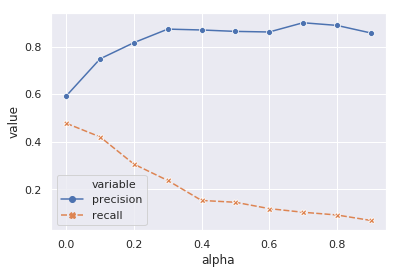

In [123]:
sns.set(style="darkgrid")
print(alpha_dict['recall'].max())
sns.lineplot(
    x='alpha',
    y='value',
    hue='variable',
    style='variable',
    markers=True,
    dashes=True,
    data=alpha_dict.melt('alpha')
)

## Realizando a mesma operação acima,

Após identificar que o parâmetro `alpha = 0.1` no MultinomialNB permite que se tenha o maior `Recall`. Com esse dado, então, os próximos experimentos terão `alpha=0.1`. É hora de mudarmos outro parâmetro.

Agora o parâmetro é `max_features` do `TfidfVectorizer`

In [124]:
max_features_dict = {
    'precision' : list(),
    'recall': list(),
    'max_features': list()
}

max_features = 500
for i in range(0,20):
    text_classifier_funcionais_balanceados = Pipeline([
        ('tfidf',TfidfVectorizer(ngram_range=(1,2), max_features=max_features)),
        ('clf',MultinomialNB(alpha=0.1)),
    ])

    text_classifier_funcionais_balanceados.fit(X_train, y_train)
    predicted_funcionais_balanceados = text_classifier_funcionais_balanceados.predict(X_test)

    output_dict = classification_report(y_test, predicted_funcionais_balanceados, output_dict=True)

    max_features_dict['recall'].append(output_dict['sim']['recall'])
    max_features_dict['precision'].append(output_dict['sim']['precision'])
    max_features_dict['max_features'].append(max_features)
    max_features = max_features + 500
    
max_features_dict = pd.DataFrame(max_features_dict)

In [125]:
max_features_dict.loc[max_features_dict['recall'].idxmax()]

max_features    3000.000000
precision          0.714286
recall             0.591603
Name: 5, dtype: float64

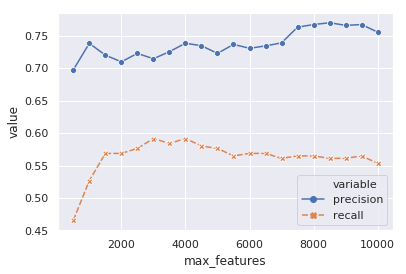

In [126]:
sns.set(style="darkgrid")
sns.lineplot(
    x='max_features',
    y='value',
    hue='variable',
    style='variable',
    markers=True,
    dashes=True,
    data=max_features_dict.melt('max_features')
)

## Não-funcionais

In [127]:
pre = _pre_review_n_funcionais + _pre_summary_n_funcionais

nao_funcionais_balanceado['pre'] = pre
nao_funcionais_balanceado['pre'] = nao_funcionais_balanceado['pre'].apply(lambda x: ' '.join(x))

X_nao_funcionais = nao_funcionais_balanceado['pre'].tolist()
y_nao_funcionais = nao_funcionais_balanceado['requirement_type'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X_nao_funcionais, y_nao_funcionais, test_size=0.3, random_state=42)

alpha_dict = {
    'precision' : list(),
    'recall': list(),
    'alpha': list()
}

alpha = 0.0
for i in range(0,10):
    
    text_classifier_nao_funcionais_balanceados = Pipeline([
        ('tfidf',TfidfVectorizer(ngram_range=(1,2))),
        ('clf',MultinomialNB(alpha=alpha)),
    ])

    text_classifier_nao_funcionais_balanceados.fit(X_train, y_train)
    predicted_nao_funcionais_balanceados = text_classifier_nao_funcionais_balanceados.predict(X_test)

    output_dict = classification_report(y_test, predicted_nao_funcionais_balanceados, output_dict=True)    
    
    alpha_dict['recall'].append(output_dict['sim']['recall'])
    alpha_dict['precision'].append(output_dict['sim']['precision'])
    alpha_dict['alpha'].append(alpha)
    alpha = alpha + 0.10
    


alpha_dict = pd.DataFrame(alpha_dict)

/home/sabinogs/.virtualenvs/explore/lib/python3.5/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/sabinogs/.virtualenvs/explore/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sabinogs/.virtualenvs/explore/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sabinogs/.virtualenvs/explore/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'pre

In [132]:
alpha_dict.loc[alpha_dict['recall'].idxmax()]

alpha        0.000000
precision    0.448276
recall       0.172185
Name: 0, dtype: float64

0.17218543046357615


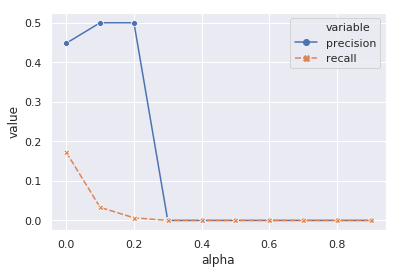

In [128]:
sns.set(style="darkgrid")
print(alpha_dict['recall'].max())
sns.lineplot(
    x='alpha',
    y='value',
    hue='variable',
    style='variable',
    markers=True,
    dashes=True,
    data=alpha_dict.melt('alpha')
)

In [139]:
pre = _pre_review_n_funcionais + _pre_summary_n_funcionais

nao_funcionais_balanceado['pre'] = pre
nao_funcionais_balanceado['pre'] = nao_funcionais_balanceado['pre'].apply(lambda x: ' '.join(x))

X_nao_funcionais = nao_funcionais_balanceado['pre'].tolist()
y_nao_funcionais = nao_funcionais_balanceado['requirement_type'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X_nao_funcionais, y_nao_funcionais, test_size=0.3, random_state=42)

max_features_dict = {
    'precision' : list(),
    'recall': list(),
    'max_features': list()
}

max_features = 500
for i in range(0,20):
    
    text_classifier_nao_funcionais_balanceados = Pipeline([
        ('tfidf',TfidfVectorizer(ngram_range=(1,2), max_features=max_features)),
        ('clf',MultinomialNB(alpha=0.01)),
    ])

    text_classifier_nao_funcionais_balanceados.fit(X_train, y_train)
    predicted_nao_funcionais_balanceados = text_classifier_nao_funcionais_balanceados.predict(X_test)

    output_dict = classification_report(y_test, predicted_nao_funcionais_balanceados, output_dict=True)    
    
    max_features_dict['recall'].append(output_dict['sim']['recall'])
    max_features_dict['precision'].append(output_dict['sim']['precision'])
    max_features_dict['max_features'].append(max_features)
    max_features += 500
    


max_features_dict = pd.DataFrame(max_features_dict)

In [140]:
max_features_dict.loc[max_features_dict['recall'].idxmax()]

max_features    1500.000000
precision          0.647059
recall             0.364238
Name: 2, dtype: float64

0.3509933774834437


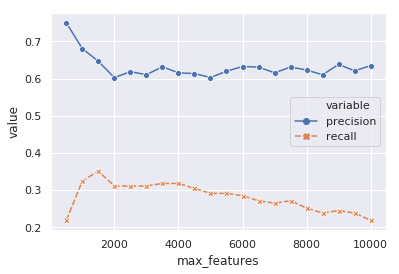

In [131]:
sns.set(style="darkgrid")
print(max_features_dict['recall'].max())
sns.lineplot(
    x='max_features',
    y='value',
    hue='variable',
    style='variable',
    markers=True,
    dashes=True,
    data=max_features_dict.melt('max_features')
)

## Resultados do Experimento 4



Através dos gráficos, pode-se observar empiricamente quais são os melhores valores para os hiper parâmetros dos algoritmos. 

Para o classificador de Requisitos Funcionais temos que: 

`alpha = 0.1 e max_features = 3000`

E para o classificador de Requisitos Não Funcionais temos:

`alpha = 0.1 e max_features = 1500.`

# Predict com uso dos classificadores balanceados.


# Model Persistence

import pickle
# text_classifier_nao_funcionais_balanceados.predict()
# text_classifier_funcionais_balanceados.predict()
# pi = pickle.dumps(text_classifier_funcionais_balanceados)

with open('../classificadores/text_classifier_nao_funcionais_balanceados', 'wb') as file:
    pickle.dump(text_classifier_nao_funcionais_balanceados, file)
    
with open('../classificadores/text_classifier_funcionais_balanceados', 'wb') as file:
    pickle.dump(text_classifier_funcionais_balanceados, file)
    
    
with open('../classificadores/text_classifier_funcionais_balanceados', 'rb') as file:
    functional_model = pickle.load(file)
    
with open('../classificadores/text_classifier_nao_funcionais_balanceados', 'rb') as file:
    nao_functional_model = pickle.load(file)
    
with open('/home/sabinogs/projetos/tcc/dump/test/reviews.bson', 'rb') as b:
    new_comments = pd.DataFrame(bson.decode_all(b.read()))
    
comments_manually_classified = new_comments[new_comments['requirement_type'].isin(['non-functional requirement', 'other', 'functional requirement'])]

comments_to_classify = new_comments.drop(comments_manually_classified.index)
comments_to_classify = comments_to_classify[['reviewText','summary','requirement_type']]

comments_to_classify['pre'] = comments_to_classify['reviewText'] + comments_to_classify['summary']
# comments_to_classify = comments_to_classify.sample(n=50000)

comments_to_classify['pre'] = comments_to_classify['pre'].apply(remove_pon).apply(_stem_it).apply(lemmatize_it).apply(lambda x: ' '.join(x))


np.mean(comments_to_classify['reviewText'].str.len())

predict_funcional = functional_model.predict(comments_to_classify['pre'])
predict_nao_funcional = nao_functional_model.predict(comments_to_classify['pre']) 

# predict_nao_funcional
comments_to_classify['predict nao funcional'] = predict_nao_funcional
comments_to_classify['predict funcional'] = predict_funcional

print(
    comments_to_classify['predict nao funcional'].value_counts(),
    comments_to_classify['predict funcional'].value_counts()
)

def classification_multilabel(document):
    
    if document['predict nao funcional'] == 'sim' and document['predict funcional'] == 'nao':
              return 'non-functional requirement'

    elif document['predict nao funcional'] == 'nao' and document['predict funcional'] == 'sim':
              return 'functional requirement'

    elif document['predict nao funcional'] == 'sim' and document['predict funcional'] == 'sim':
              return 'non-functional requirement'
            
    elif document['predict nao funcional'] == 'nao' and document['predict funcional'] == 'nao':
              return 'other'
    else:
        return 'non-functional requirement'
    
    
comments_to_classify['Predicao Intermediaria'] = comments_to_classify.apply(classification_multilabel, axis=1)
np.unique(comments_to_classify['Predicao Intermediaria'])

p = comments_to_classify[['Predicao Intermediaria','reviewText', 'summary']]


# p.to_json('comentarios_classificacao_automatica.json', orient='records')

import json

with open('comentarios_classificacao_automatica.json','r') as file:
    p = pd.DataFrame(json.load(file))
    
p = p[['Predicao Intermediaria','reviewText','summary']]
p.to_json('p_comentarios_classificacao_automatica.json', orient='records')

with open('comentarios_classificacao_automatica.json','r') as file:
    p = json.load(file)